## Observation Planning for proposals 

In this workshop, you will prepare an observation proposal for the LST located on La Palma. 
This tutorial will enable you to complete the sections on the observation parameters and the technical justification.

To start with, we assume that you already know a) the science case for gamma-ray emission, b) a specific target located on the sky, and c) the anticipated gamma-ray flux. 

We will now address the following questions:
1. Is the source visible by the LST?
2. How much time do I need to reach a 5$\sigma$ detection?
3. What role do the zenith angle and Night Sky Background play? 
4. How do I determine a good observation strategy?
5. What total observation time should be requested? 

### 2: time

In this notebook we address the issue of estimating the amount of observing time needed. 

*Note*: this is just **one** of **two** approaches - for the second, please refer to the colab notebook `Estimate_Time_tool.ipynb` which is correct for LST-1. 

*Caveat*: This notebook is just a demonstration and is quantitatively correct only for the case of 4 x LSTs.

In [1]:
#First import some useful packages:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord

from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom

%matplotlib inline

For the purposes of this notebook and the next (2 and 3) you will need to obtain the LST sub-array IRFs from the CTA official set: [CTA_prod5-IRFs_Zenodo](https://zenodo.org/doi/10.5281/zenodo.5499839)

In [2]:
#Extract the FITS files and give the path to where they are located for you: 

filepath = "cta-prod5-zenodo-fitsonly-v0.1/fits/"

filename = "CTA-Performance-prod5-v0.1-North-LSTSubArray-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs.180000s-v0.1.fits"

IRFs = load_irf_dict_from_file(filepath+filename)

These IRF files are defined for a given site (CTA-North) telescope combination (4 x LSTs = the LST sub-array) zenith angle (20 degrees) azimuthal angle (averaged) and observation time (50 hours = 180000s). 

They contain the effective area, point spread function, energy dispersion and background.

In [3]:
IRFs.keys()

dict_keys(['aeff', 'psf', 'edisp', 'bkg'])

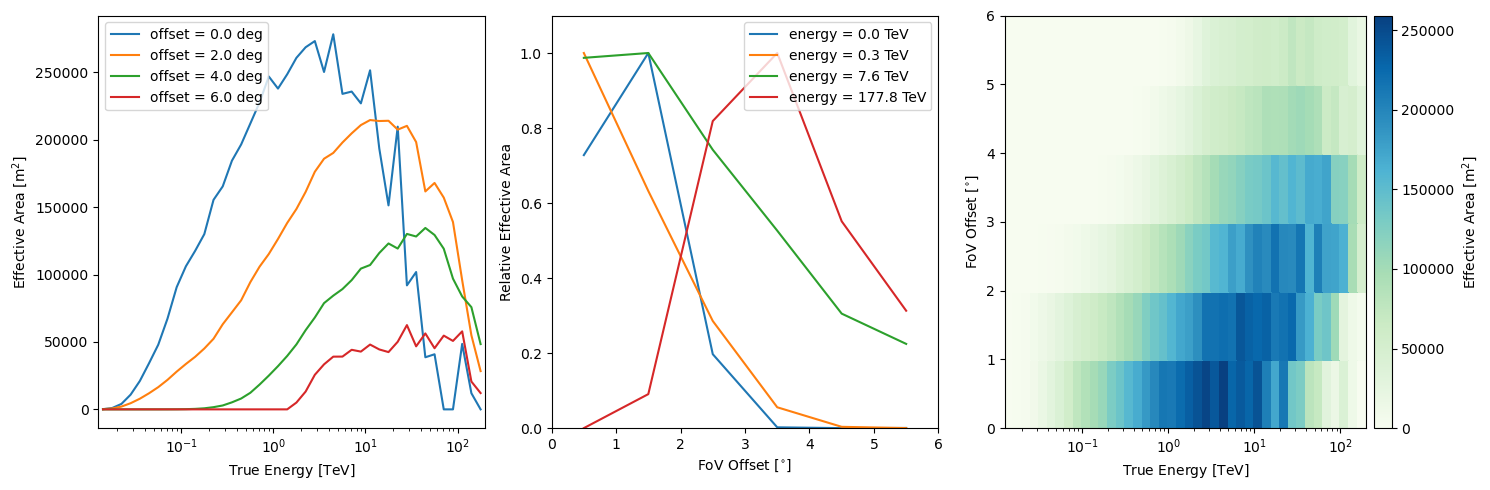

In [4]:
#Take a look at the effective area 
IRFs["aeff"].peek()

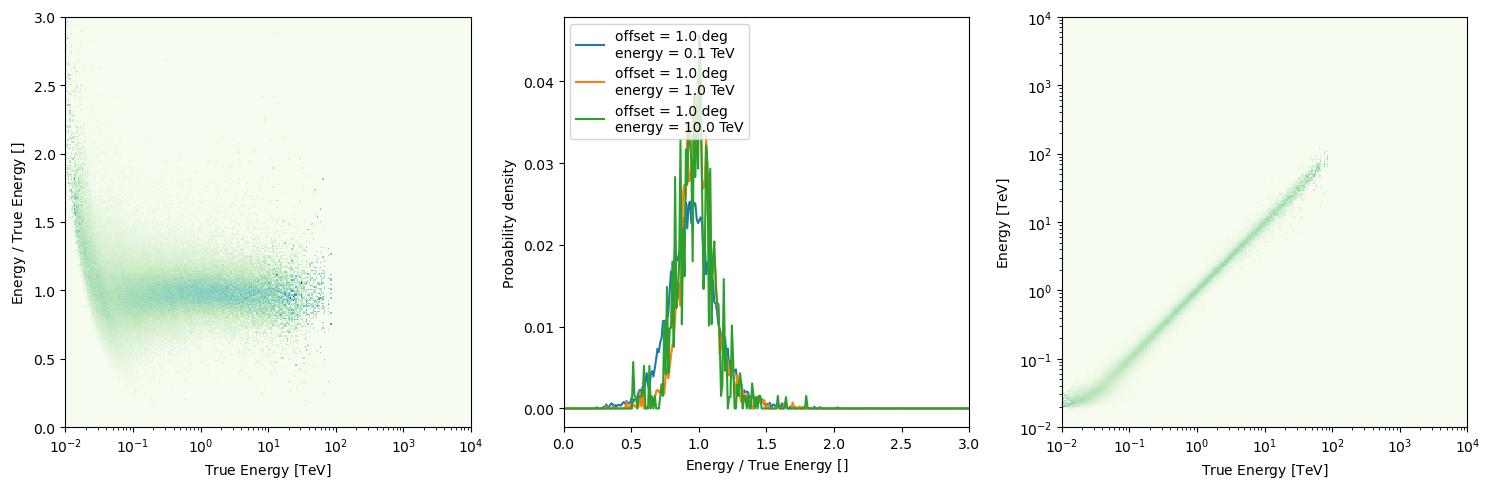

In [5]:
#Take a look at the energy dispersion
IRFs["edisp"].peek()

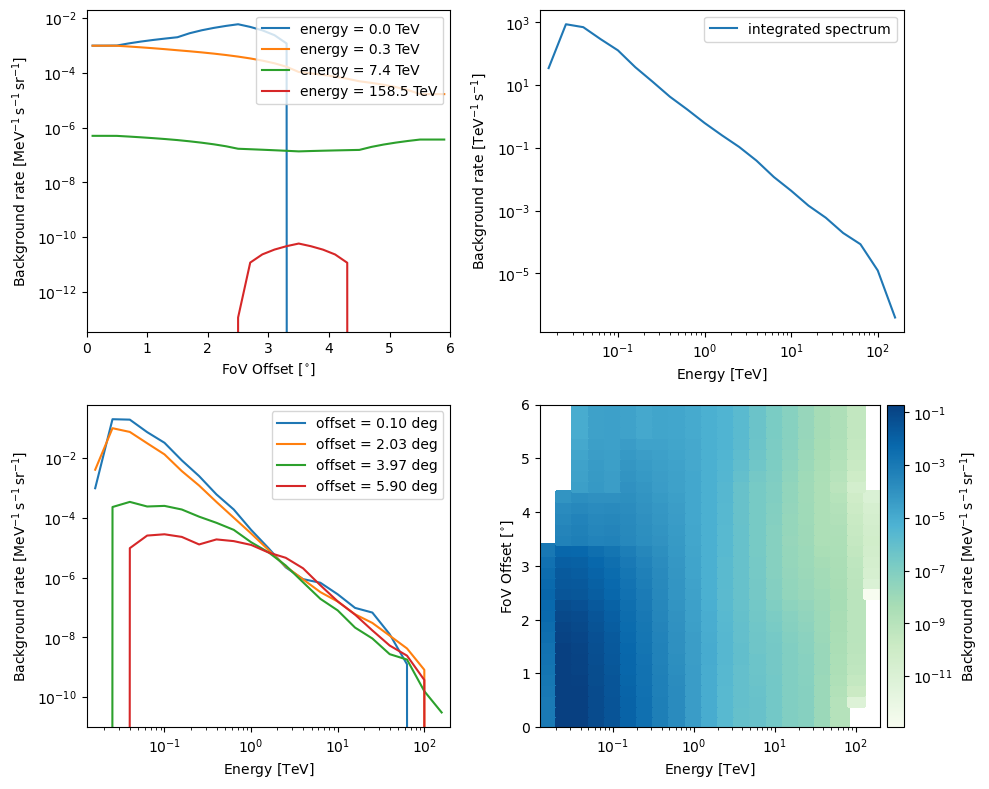

In [6]:
#Take a look at the background
IRFs["bkg"].peek()

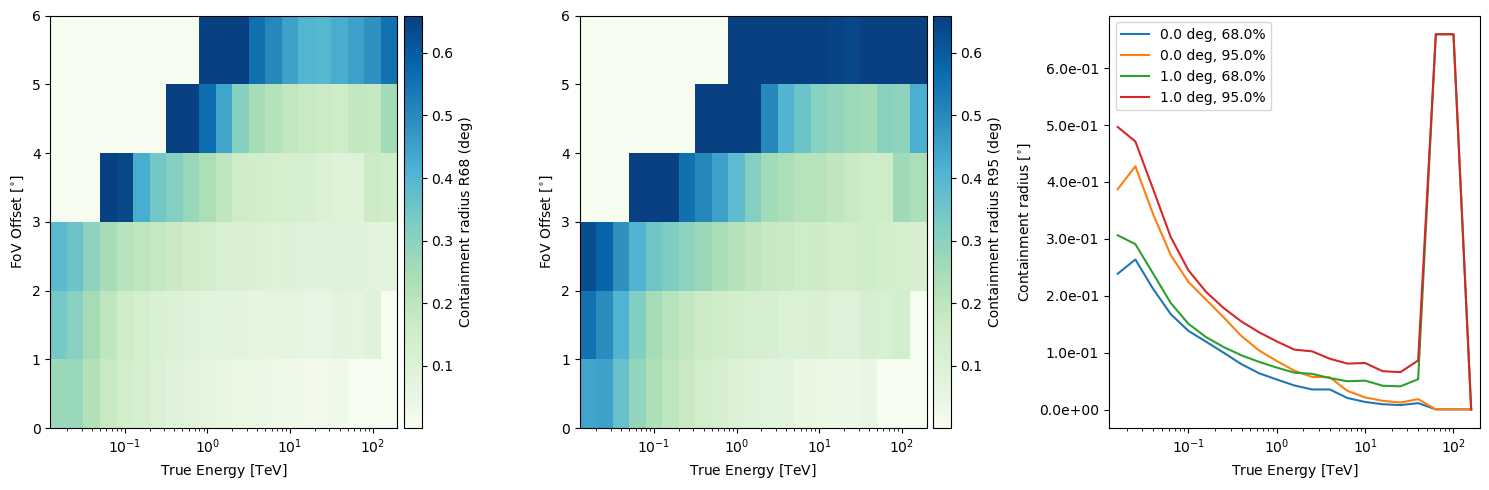

In [7]:
#Take a look at the point spread function
IRFs["psf"].peek()

### How much time is needed? 

First we define an energy axis and choose a source. In this case, we select the Crab nebula. 

In [8]:
# pointing = SkyCoord.from_name('crab')
pointing = SkyCoord.from_name('Mkn501')
print(pointing.ra.deg,pointing.dec.deg)

253.467569516792 39.760169132056


In [9]:
pointing.dec.hour

2.650677942137067

In [10]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "200 TeV", nbin=25)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "300 TeV", nbin=100, name="energy_true"
)
#source 0.5 degree offset from pointing position, 0.1 degree radius exclusion region 
# geom = RegionGeom.create("icrs;circle(83.6287, 22.5147, 0.1)", axes=[energy_axis])
geom = RegionGeom.create("icrs;circle(253.467569516792, 39.260169132056, 0.1)", axes=[energy_axis])

#Create an empty dataset
empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

* Set the location and create an observation object. 
* Then run the spectrum maker
* Estimate the sensitivity using the criteria per energy bin: 
    - A minimum of 10 gamma-ray counts
    - A minimum significance of 5 sigma
    - A background systematic of 10% maximum

In [11]:
location = observatory_locations["cta_north"]

obs = Observation.create(
    pointing=pointing, irfs=IRFs, livetime="50 h", location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset = spectrum_maker.run(empty_dataset, obs)

/Users/luanareis/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [12]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

In [13]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

energy,e_ref,e_min,e_max,e2dnde,excess,background,criterion
TeV,TeV,TeV,TeV,erg / (s cm2),,,
float64,float64,float64,float64,float64,float64,float64,bytes12
0.0357766,0.0357766,0.03,0.0426656,1.37741e-12,390.246,3902.46,bkg
0.050881,0.050881,0.0426656,0.0606784,1.32402e-12,355.12,3551.2,bkg
0.0723623,0.0723623,0.0606784,0.0862959,8.65342e-13,281.496,2533.29,significance
0.102913,0.102913,0.0862959,0.122729,7.49195e-13,232.367,1710.87,significance
0.146361,0.146361,0.122729,0.174543,6.85323e-13,175.59,960.852,significance
0.208152,0.208152,0.174543,0.248233,5.71664e-13,130.428,517.727,significance
...,...,...,...,...,...,...,...
28.8251,28.8251,24.1708,34.3754,1.28296e-11,10.3916,0.694215,significance


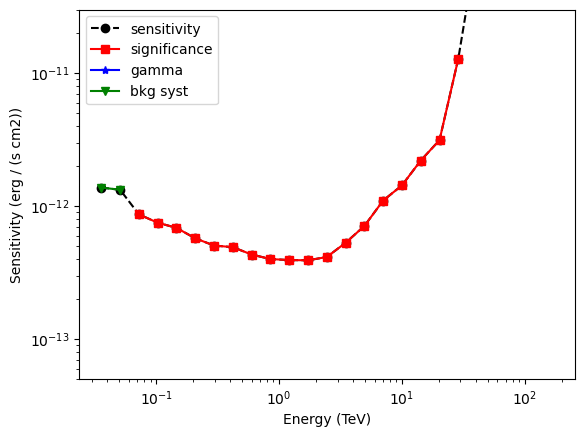

In [14]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS):
# sensitivity_table.write('sensitivity_prod5_CTAS_50h.csv', format='csv')

# Plot the sensitivity curve - split according to the criterion dominating the sensitivity
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()

#Also plot the total significance curve
ax.plot(t["energy"],t["e2dnde"],"o--",color="k",label="sensitivity")

ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)


ax.loglog()
ax.set_xlabel(f"Energy ({t['energy'].unit})")
ax.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})")
ax.set_ylim(5e-14,3e-11)
ax.legend()

None

This is interesting, but it probably does not make sense to really use the LST sub-array alone for sources above ~10 TeV, as high energy events will be truncated. 

Let's instead just plot the sensitivity curve up to 10 TeV, and compare it to a reference spectrum for the Crab nebula, as well as for an extragalactic source, e.g. 1ES 0229+200.

In [15]:
#We import some spectral models and consider two sources
from gammapy.modeling.models import PowerLawSpectralModel,LogParabolaSpectralModel

In [16]:
#1.1e-8 ph cm-2 s-1 (0.1 to 100 GeV)
#1.3e-10 MeV cm-2 s-1
#Flux is 3.6e-12 at 0.521 but gammapy needs specific units of cm-2 s-1 TeV-1
print(1.1e-8 / 0.100)

1.0999999999999999e-07


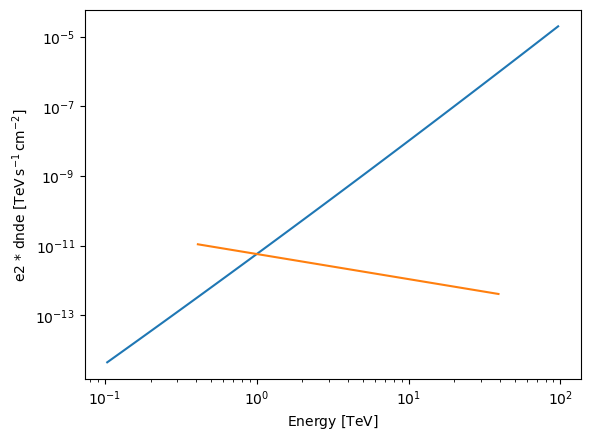

In [17]:
# Define spectral model - a Power Law and a log parabola
energy_bounds = [0.1, 100] * u.TeV
en_bounds_less = [0.4,40] * u.TeV

#Log parabola model from Fermi-LAT
model_logp = LogParabolaSpectralModel(
    alpha=-1.2,
    amplitude="5.78e-12 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=-0.02,
)

#Model from doi:10.1088/0004-637X/729/1/2
model_pl = PowerLawSpectralModel(
    index=2.72,
    amplitude=5.78e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)

model_logp.plot(energy_bounds,energy_power=2)
model_pl.plot(en_bounds_less,energy_power=2)

None

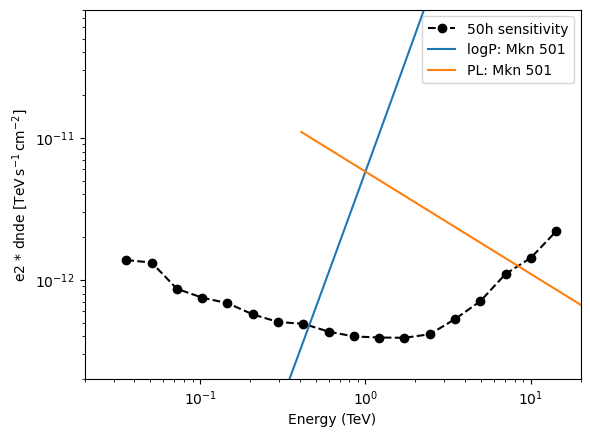

In [18]:
fig, ax = plt.subplots()

emask = t["energy"] < 20.
#Plot the total significance curve
ax.plot(t["energy"][emask],t["e2dnde"][emask],"o--",color="k",label="50h sensitivity")
model_logp.plot(energy_bounds,energy_power=2,label="logP: Mkn 501")
model_pl.plot(en_bounds_less,energy_power=2,label="PL: Mkn 501")

ax.loglog()
ax.set_xlabel(f"Energy ({t['energy'].unit})")
# ax.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})")
ax.set_ylim(2e-13,8e-11)
ax.set_xlim(0.02,20.)
ax.legend()

None

So much for the Crab - clearly detectable in 50 hours, but we run out of sensitivity above 10 TeV with the LST array. 

What about shorter observation times, e.g. 5 hours or 0.5 hours? Let's load those IRFs and see how the sensitivities compare.

In [19]:
filename5 = "CTA-Performance-prod5-v0.1-North-LSTSubArray-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs.18000s-v0.1.fits"
IRFs5 = load_irf_dict_from_file(filepath+filename5)
filename_half = "CTA-Performance-prod5-v0.1-North-LSTSubArray-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs.1800s-v0.1.fits"
IRFs_half = load_irf_dict_from_file(filepath+filename_half)


In [20]:
obs5 = Observation.create(
    pointing=pointing, irfs=IRFs5, livetime="5 h", location=location
)

spectrum_maker5 = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset5 = spectrum_maker5.run(empty_dataset, obs5)

obs_half = Observation.create(
    pointing=pointing, irfs=IRFs_half, livetime="0.5 h", location=location
)

spectrum_maker_half = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset_half = spectrum_maker_half.run(empty_dataset, obs_half)

dataset_on_off_5 = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset5, acceptance=1, acceptance_off=5
)
dataset_on_off_half = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset_half, acceptance=1, acceptance_off=5
)

sens_t5 = sensitivity_estimator.run(dataset_on_off_5)
sens_thalf = sensitivity_estimator.run(dataset_on_off_half)

/Users/luanareis/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/Users/luanareis/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/data/observations.py:281: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


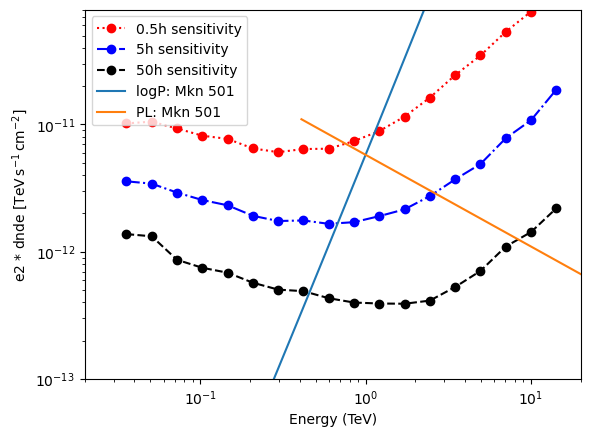

In [21]:
fig, ax = plt.subplots()

ax.plot(sens_thalf["energy"][emask],sens_thalf["e2dnde"][emask],"o:",color="r",label="0.5h sensitivity")
ax.plot(sens_t5["energy"][emask],sens_t5["e2dnde"][emask],"o-.",color="b",label="5h sensitivity")
ax.plot(t["energy"][emask],t["e2dnde"][emask],"o--",color="k",label="50h sensitivity")
model_logp.plot(energy_bounds,energy_power=2,label="logP: Mkn 501")
model_pl.plot(en_bounds_less,energy_power=2,label="PL: Mkn 501")

ax.loglog()
ax.set_xlabel(f"Energy ({t['energy'].unit})")
ax.set_ylim(1e-13,8e-11)
ax.set_xlim(0.02,20.)
ax.legend()


None

### How to estimate required observation time:

* Estimate spectrum / flux level
* Interpolate between sensitivity curves at a given energy for a certain time (for 5 sigma detection / meeting the criteria defined above) 
* Scale according to PSF and expected source size for extended source (see also dedicated studies on this) 
* Estimate that sensitivity goes as sqrt(t) for increased significance (desireable for detailed studies)


In [22]:
from scipy.interpolate import interp1d

In [23]:
sens50h_interp = interp1d(t["energy"],t["e2dnde"])
sens5h_interp = interp1d(sens_t5["energy"],sens_t5["e2dnde"])
senshalf_interp = interp1d(sens_thalf["energy"],sens_thalf["e2dnde"])

In [24]:
#Evaluate spectral model at a given energy:
# low_E = model_logp.evaluate(energy=0.2*u.TeV,amplitude=model_logp.amplitude,
                            # reference=1.*u.TeV,alpha=model_logp.alpha.value,beta=model_logp.beta.value)

low_E = model_pl.evaluate(energy=0.2*u.TeV,amplitude=model_pl.amplitude,
                            reference=1.*u.TeV,index=model_pl.index.value)

low_E2 = low_E*0.2*u.TeV*0.2*u.TeV
print(low_E2)

1.8415615618948538e-11 TeV / (s cm2)


In [25]:
from scipy.optimize import curve_fit

In [26]:
t_x = [0.5,5.,50.]
t_y = [senshalf_interp(1.*u.TeV),sens5h_interp(1.*u.TeV),sens50h_interp(1.*u.TeV)]

In [27]:
#Define a fit function to run between the sensitivity curves:
def test_func(x,a,b):
    y = 10.**(a*np.log10(x) + b)
    return y

In [28]:
p, err = curve_fit(test_func,t_x,t_y)

In [29]:
print(p,err)

[ -0.65128604 -11.29205923] [[4.89153663e-07 1.21782498e-07]
 [1.21782498e-07 5.67688529e-08]]


Now plot how the sensitivity changes with time at 1 TeV based on these sensitivity curves:

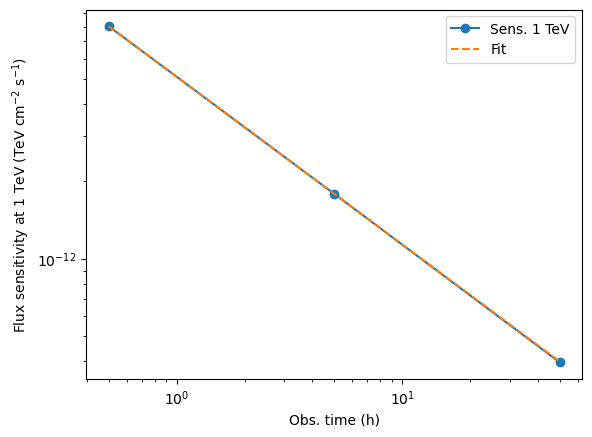

In [30]:
plt.plot(t_x,t_y,"o-",label="Sens. 1 TeV")
plt.plot(t_x,test_func(np.array(t_x),p[0],p[1]),"--",label="Fit")
plt.semilogx()
plt.semilogy()
plt.xlabel("Obs. time (h)")
plt.ylabel("Flux sensitivity at 1 TeV (TeV cm$^{-2}$ s$^{-1}$)")
plt.legend()
None

In [31]:
#Let's work out how long the LST sub-array will need to detect it 

logp_flux_1tev = model_logp.evaluate(energy=1*u.TeV,
                                     amplitude=model_logp.amplitude,
                                     alpha=model_logp.alpha.value,
                                     beta=model_logp.beta.value,
                                    reference=model_logp.reference)

pl_flux_1tev = model_pl.evaluate(energy=1.*u.TeV,
                                 amplitude=model_pl.amplitude,
                                 index=model_pl.index.value,
                                 reference=model_pl.reference)

In [32]:
logp_flux_1tev

<Quantity 5.78e-12 1 / (TeV s cm2)>

In [33]:
pl_flux_1tev

<Quantity 5.78e-12 1 / (TeV s cm2)>

Now we simply need to inverse the fitted function to evaluate the corresponding observation time required for a 5 sigma detection at 1 TeV. 

In [34]:
def flux_to_time(fl_sens,params):
    arg = (np.log10(fl_sens) - params[1])/params[0]
    return 10**arg
    
time_needed = flux_to_time(pl_flux_1tev.value,p)
print("Time needed to detect at 5 sigma = %.3f hours"%(time_needed))

Time needed to detect at 5 sigma = 0.826 hours


Significance should increase as a function of time as $\propto \sqrt{t}$, so when can we expect a $10\,\sigma$ detection? 

In [35]:
k = 5 / np.sqrt(time_needed)
time10 = (10/k)**2.
print("After %.3f hours"%(time10))

After 3.305 hours


#### Reaching a sensitivity level without a source spectrum
What about if we want to reach a certain sensitivity level e.g. to place upper limits, but without assuming a spectrum?

Simply evaluate the ``flux_to_time`` function for the desired flux at 1 TeV.

In [36]:
#e.g. 1e-12 at 1 TeV:
print("Time needed to detect at 5 sigma = %.3f hours"%(flux_to_time(1e-12,params=p)))

Time needed to detect at 5 sigma = 12.218 hours


For a different energy normalisation, the interpolation of sensitivity curves and linear fit will need to be redone at the corresponding energy. 

Task: Try evaluating how much time would be required to reach a sensitivity of 1e-13 TeV / cm$^{2}$s at 500 GeV: 

#### Extended sources
So much for point sources. What about if the source is extended? 
Ideally, we can use IRFs suitable for extended sources. 
However, in their absence we can adopt a simple scaling arguement, namely that the sensitivity scales with the size of the source as $\propto \sqrt{\sigma^2_{\rm source}+\sigma^2_{\rm PSF}}$

To work out how much extra time we need for an extended source, let's first evaluate the PSF.

In [37]:
psf50 = IRFs["psf"].containment_radius(0.68,energy_true=1.*u.TeV,offset=0.4*u.deg)
psf5 = IRFs5["psf"].containment_radius(0.68,energy_true=1.*u.TeV,offset=0.4*u.deg)
psf_half = IRFs_half["psf"].containment_radius(0.68,energy_true=1.*u.TeV,offset=0.4*u.deg)
print(psf50,psf5,psf_half)

0.06125 deg 0.06975 deg 0.10825000000000001 deg


Now let's consider a hypothetical source with the same power law index and flux normalisation as 1ES 0229+200, but is a galactic source with an expected radius of 0.3 degrees. 

In [38]:
ext_scale_factor = np.sqrt(0.3**2.+psf50.value**2.)
print(ext_scale_factor,1./ext_scale_factor)

0.3061887693890813 3.2659591074984085


Hence the required observing time is increased accordingly: 

In [39]:
flux_to_time(pl_flux_1tev.value*ext_scale_factor,p)

5.085471709921313

Task: Try doing this for another energy and for a different source / with a different spectral model.

### Major caveat: LST sub-array vs LST-1

All of the above was done using IRFs suitable for the complete LST sub-array, i.e. for four telescopes. 
However, you need to write an observation proposal for a single telescope, LST-1. How can we revise the time estimate above? 
For single telescope observations, the background rate (surviving cuts) will be higher than for stereo observations, such that a longer observing time is typically required. 

An additional notebook on guesstimating an appropriate scaling is also provided, `CTAO_school_2024_Obs_Planning_5-ScaleTimeLST.ipynb`

### IACT time estimator

Now we refer to the full calculation. See also the colab notebook that uses this tool: 
https://github.com/cta-observatory/iact-estimator

Here we simply plot the pre-provided rate information for illustration.

In [40]:
#Rate information provided by LST collaboration for LST-1 mono and low zenith angles 
#Based on cuts optimised for 50 h:

min_en = np.array([25.1,39.8,63.0,100.0,158.0,251.0,398.0,631.0,1000.0,1585.0,2512.0,3981.0,6310.0,10000.0])
max_en = np.array([39.8,63.0,100.0,158.0,251.0,398.0,631.0,1000.0,1585.0,2512.0,3981.0,6310.0,10000.0,15848.9])
crabrate = np.array([0.4337586, 0.3431082, 0.4269354, 2.07327, 2.610834,2.533182, 1.312488, 0.817482, 0.65421, 0.4729104, 0.2849484, 0.161319, 0.0999108, 0.04191378])
bgdrate = np.array([7.87152, 6.26364, 1.99188, 1.684836, 0.737388,0.2984322, 0.05556012, 0.01884492, 0.01640808, 0.01299648,0.01234668, 0.0121842, 0.01072212, 0.01169688])

In [41]:
#and for 30 minutes:
crabrate_half = np.array([6.57216, 9.6801, 7.38072, 3.163998, 4.201608,
                             3.293964, 2.79945, 1.872636, 1.237266, 0.774102,
                             0.3543174, 0.229551, 0.1192428, 0.05750958])
bgdrate_half = np.array([4.045824e+02, 3.973140e+02, 1.703196e+02, 4.414590e+00,
                            1.925598e+00, 5.045898e-01, 2.797500e-01, 1.255788e-01,
                            9.178800e-02, 4.662498e-02, 2.534322e-02, 4.045164e-02,
                            3.720252e-02, 2.583054e-02])

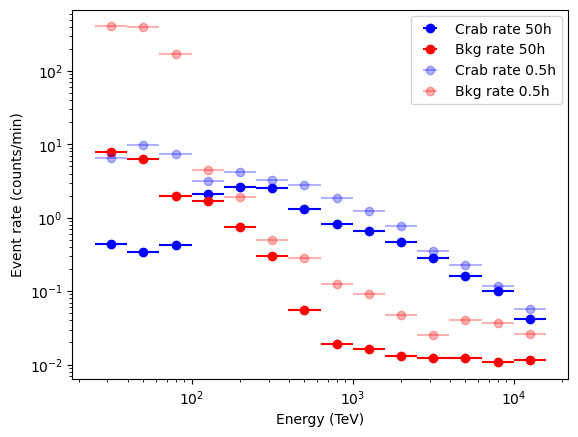

In [42]:
mid_en = 10.**((np.log10(min_en)+np.log10(max_en))/2.)

plt.errorbar(mid_en,crabrate,xerr=[mid_en-min_en,max_en-mid_en],fmt="bo",label="Crab rate 50h")
plt.errorbar(mid_en,bgdrate,xerr=[mid_en-min_en,max_en-mid_en],fmt="ro",label="Bkg rate 50h")
plt.errorbar(mid_en,crabrate_half,xerr=[mid_en-min_en,max_en-mid_en],fmt="bo",label="Crab rate 0.5h",alpha=0.3)
plt.errorbar(mid_en,bgdrate_half,xerr=[mid_en-min_en,max_en-mid_en],fmt="ro",label="Bkg rate 0.5h",alpha=0.3)

plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel("Energy (TeV)")
plt.ylabel("Event rate (counts/min)")

None